In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
"""
all_array = []
x = np.linspace(0, 100, 1000)
for i in range(500):
    k2 =np.random.random()
    k1 =np.random.random()
    signal = np.cos(k1*x) + np.sin(k2*x)
    all_array.append(signal)
for j in range(100):
    k2 =np.random.random()
    k1 =k2**2
    signal = np.cos(k1*x) + np.sin(k2*x)
    all_array.append(signal)

all_array = np.array(all_array)
"""

'\nall_array = []\nx = np.linspace(0, 100, 1000)\nfor i in range(500):\n    k2 =np.random.random()\n    k1 =np.random.random()\n    signal = np.cos(k1*x) + np.sin(k2*x)\n    all_array.append(signal)\nfor j in range(100):\n    k2 =np.random.random()\n    k1 =k2**2\n    signal = np.cos(k1*x) + np.sin(k2*x)\n    all_array.append(signal)\n\nall_array = np.array(all_array)\n'

In [3]:
def creneau_function(x, x1, eps2):
    """Returns 1 if x is between x1 and x1 + eps2, else returns 0."""
    return np.where((x > x1) & (x < x1 + eps2), 1, 0)


In [4]:
x1_list = [np.absolute(np.random.normal(50, 15)) for i in range(1000)]
eps2_list = [np.absolute(np.random.normal(20, 5)) for i in range(1000)]

In [5]:
all_array = []
x = np.linspace(0, 100, 1000)
for i in range(1000):
    x1 = x1_list[i]
    eps2 = eps2_list[i]
    signal = [creneau_function(xx, x1, eps2) for xx in x]
    all_array.append(signal)
all_array = np.array(all_array)

In [6]:

def split_function(x, a, b):
    n = x.shape[0]
    output = np.ones_like(x)
    
    # For first half, use normal distribution with mean 'a'
    output[:n//2] = np.random.normal(a, 1, size=n//2)
    
    # For second half, use normal distribution with mean 'b'
    output[n//2:] = np.random.normal(b, 1, size=n - n//2)
    
    return output

In [7]:
a_list = [np.random.normal(0, 1) for i in range(1000)]
b_list = [np.random.normal(0, 1) for i in range(1000)]

In [8]:
all_array = []
x = np.linspace(0, 100, 1000)
for i in range(1000):
    a = a_list[i]
    b = b_list[i]
    signal = split_function(x, a, b)
    all_array.append(signal)
all_array = np.array(all_array)

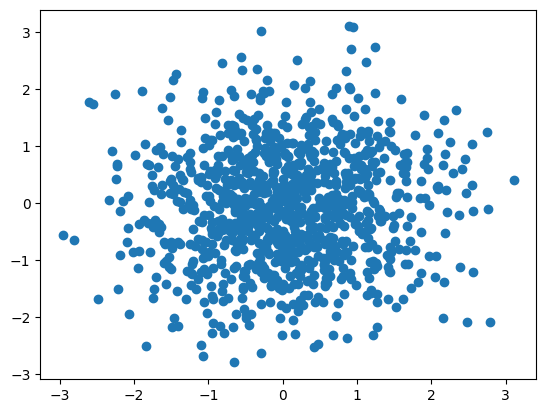

In [9]:
plt.scatter(a_list, b_list)

In [10]:
all_array.shape

(1000, 1000)

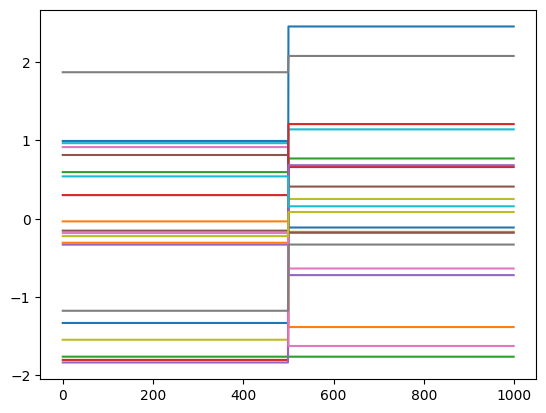

In [11]:
for i in range(20):
    plt.plot(all_array[i])

In [12]:
# Set the split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
total_samples = all_array.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle the data (optional, but common in dataset splitting)
indices = np.random.permutation(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = all_array[train_indices]
val_data = all_array[val_indices]
test_data = all_array[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching during training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [14]:
# Define the VAE model as a fully connected network
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=250, latent_dim=125, device='cpu'):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        # Latent space (mean and log variance)
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            #nn.Sigmoid()  # Output scaled between 0 and 1
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        epsilon = torch.randn_like(std)  # Random noise
        return mean + epsilon * std  # Reparameterization trick
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        return self.decode(z), mean, logvar

# Loss function (reconstruction loss + KL divergence)
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss

In [15]:

_, input_dim = all_array.shape

# Instantiate the VAE
latent_dim = 80  # Latent space dimension
vae = VAE(input_dim=input_dim)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=5e-5)


In [16]:
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
min_delta = 0  # Minimum change to qualify as an improvement
best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 0  # Count how long the validation loss hasn't improved

# Training loop with early stopping
epochs = 500
for epoch in range(epochs):
    total_loss = 0
    vae.train()  # Set VAE to training mode
    
    # Training step
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar, beta=1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}", end="\r")
    
    # Validation step
    vae.eval()  # Set VAE to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_batch in val_loader:
            x_val = val_batch[0]
            recon_x_val, mu_val, logvar_val = vae(x_val)
            val_loss = vae_loss(recon_x_val, x_val, mu_val, logvar_val, beta=1)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}",end="\r")

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
    
    # Check if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Ensure the final epoch result is printed properly
print(f"Training Complete. Final Train Loss: {avg_train_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")


Early stopping triggered at epoch 113al Loss: 14.8064
Training Complete. Final Train Loss: 15.1910, Best Val Loss: 13.8378


In [17]:
# Test the VAE with a batch of images
vae.eval()  # Set VAE to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of images from the DataLoader
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
arrays = next(data_iter)  # Get a batch of images

# Since there's only one tensor in the dataset, access it with [0]
arrays = arrays[0].to(device)  # Move to GPU if available

# Pass the images through the VAE
with torch.no_grad():
    reconstructed_images = vae(arrays)  # Decode the images
    reconstructed_images = reconstructed_images[0]
    mu, logvar = vae.encode(arrays)
    mu_np = mu.detach().cpu().numpy()  

In [18]:
mu_np.shape

(32, 2)

In [19]:
print(arrays.shape, reconstructed_images.shape, mu_np.shape)

torch.Size([32, 1000]) torch.Size([32, 1000]) (32, 2)


3.93 -1.78 tensor(-0.8240) tensor(-2.0191)


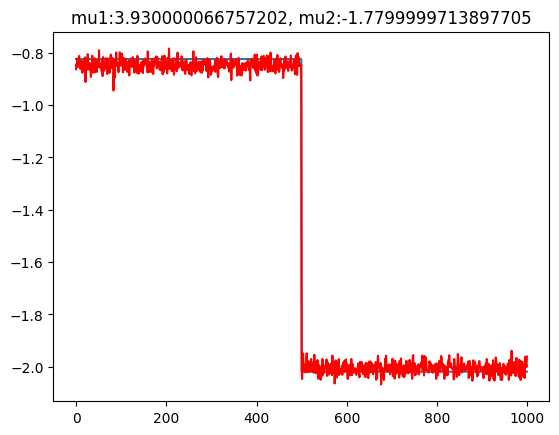

-1.98 -0.39 tensor(0.8143) tensor(0.4109)


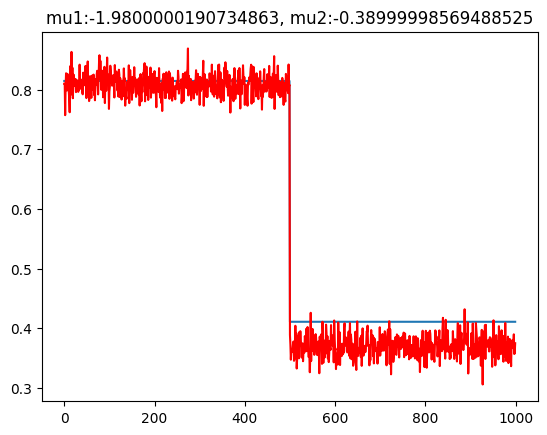

1.58 4.04 tensor(-1.7972) tensor(1.0326)


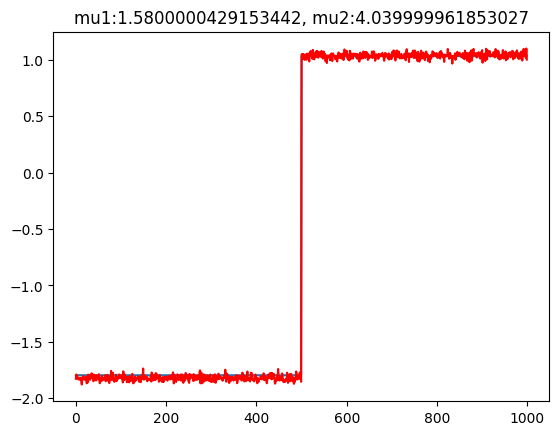

-1.49 0.1 tensor(0.4847) tensor(0.4544)


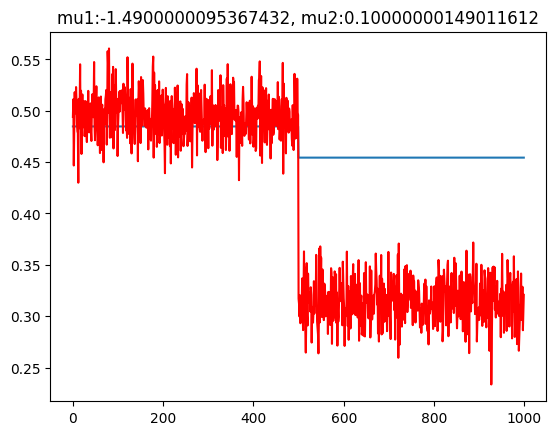

-0.85 -2.33 tensor(1.0341) tensor(-0.6264)


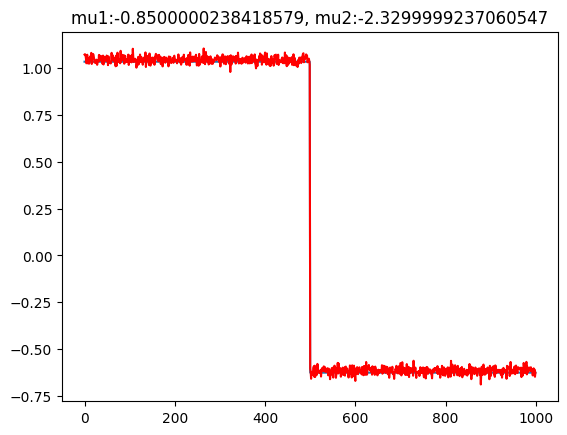

-1.28 4.98 tensor(-0.7653) tensor(2.2199)


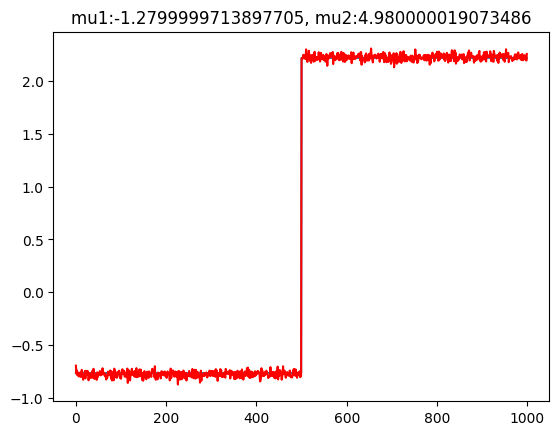

2.58 -1.08 tensor(-0.5799) tensor(-1.2899)


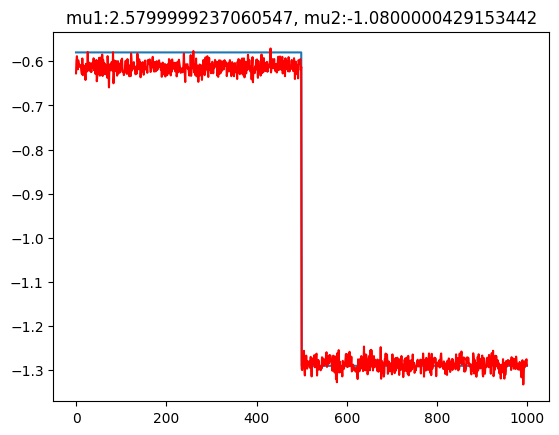

-1.27 -1.41 tensor(0.8712) tensor(-0.1609)


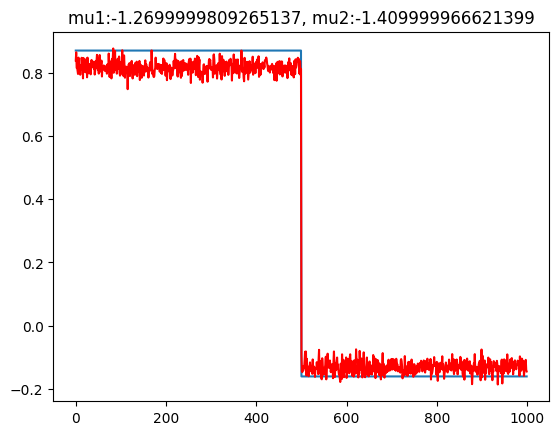

1.78 0.72 tensor(-0.8909) tensor(-0.3136)


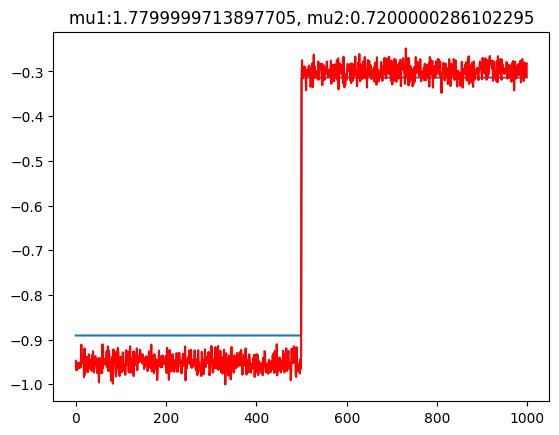

0.12 1.24 tensor(-0.4067) tensor(0.4077)


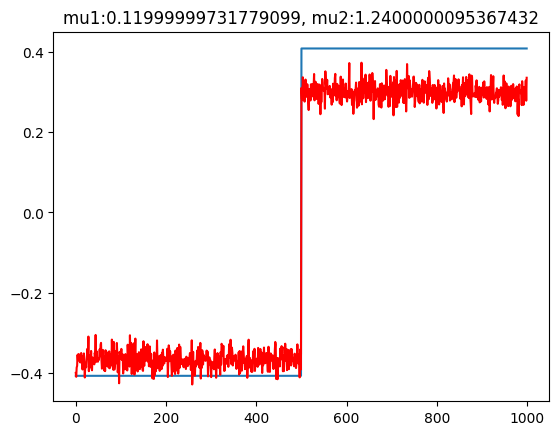

0.34 -3.32 tensor(0.9759) tensor(-1.3670)


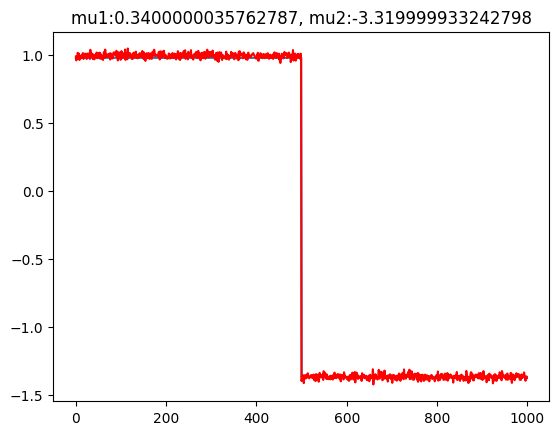

-0.13 -0.12 tensor(0.0358) tensor(-0.0247)


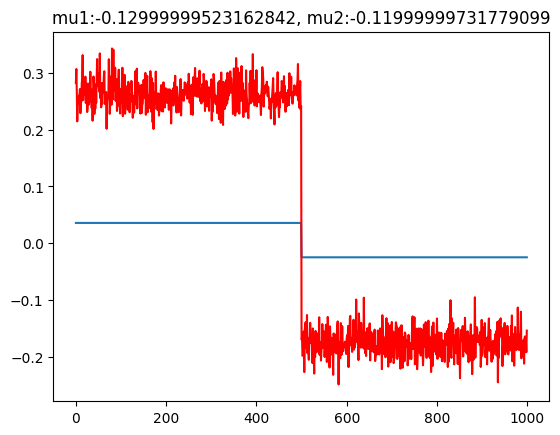

3.0 -0.56 tensor(-0.9156) tensor(-1.2158)


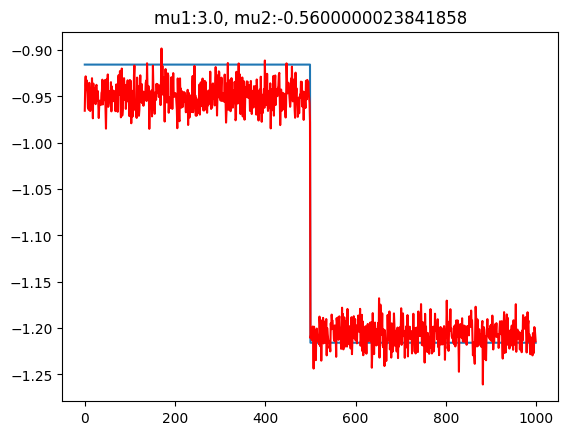

-0.79 2.49 tensor(-0.3439) tensor(1.1282)


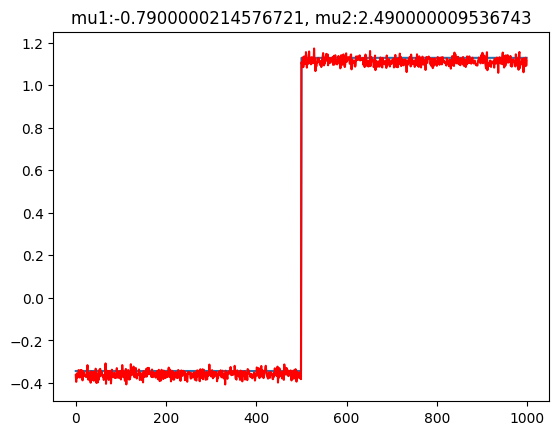

-1.0 3.67 tensor(-0.5523) tensor(1.6404)


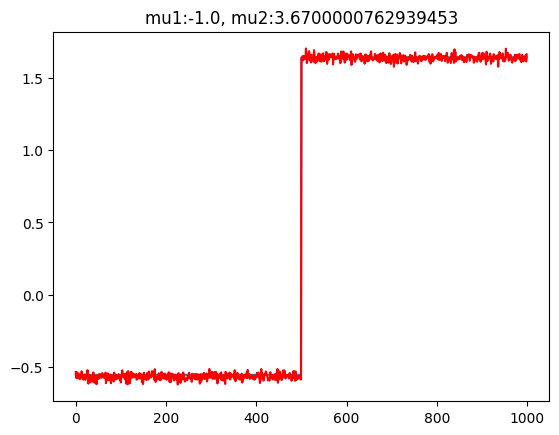

-2.6 -1.18 tensor(1.2906) tensor(0.2992)


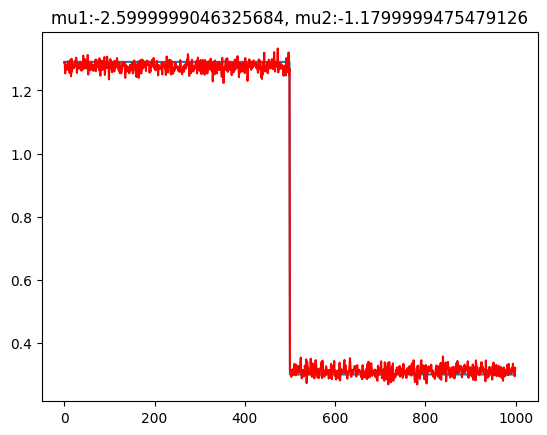

3.05 0.97 tensor(-1.4432) tensor(-0.6173)


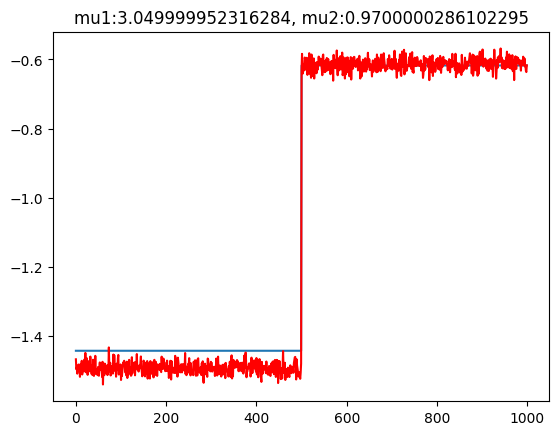

-0.64 1.56 tensor(-0.1718) tensor(0.7308)


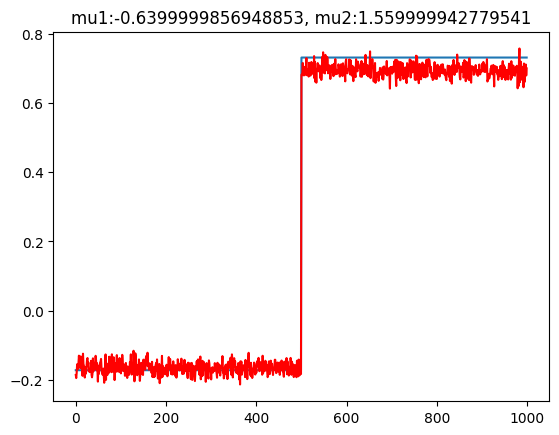

1.62 2.31 tensor(-1.3109) tensor(0.3591)


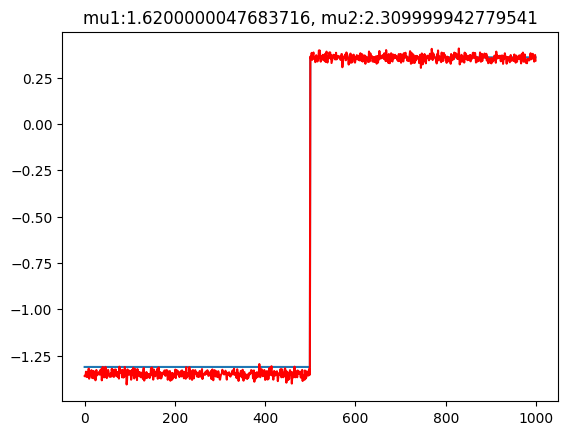

-2.39 1.75 tensor(0.4701) tensor(1.2816)


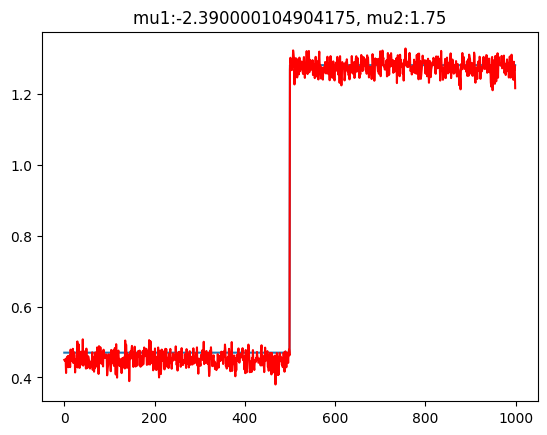

0.88 -0.67 tensor(-0.1021) tensor(-0.5602)


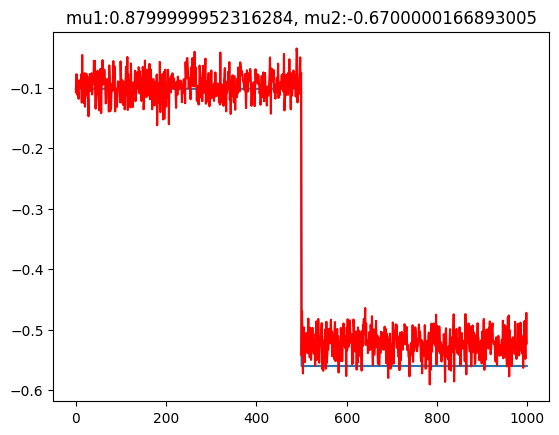

1.14 1.03 tensor(-0.7447) tensor(0.0093)


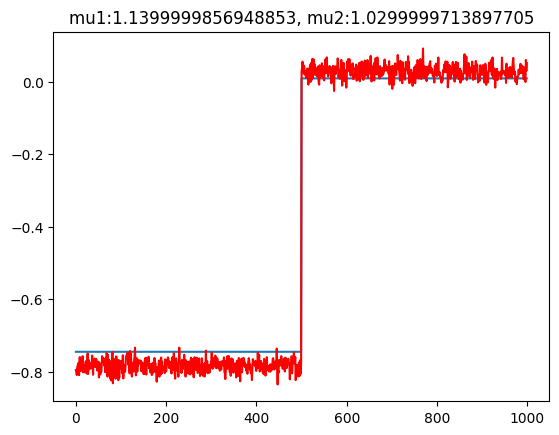

0.64 -4.6 tensor(1.3140) tensor(-1.9428)


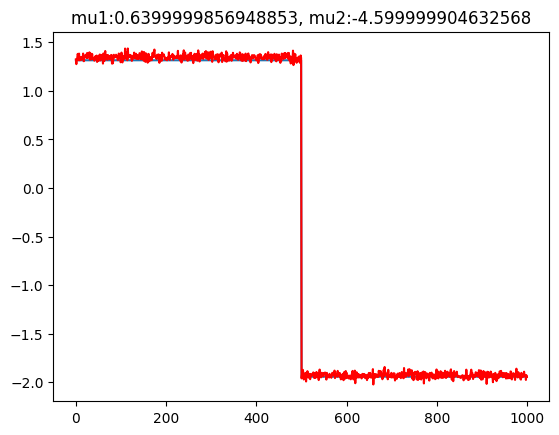

-3.12 0.62 tensor(0.9656) tensor(1.1416)


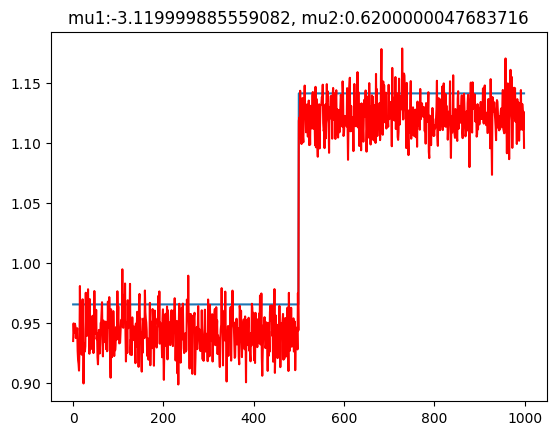

-1.37 0.65 tensor(0.3247) tensor(0.5922)


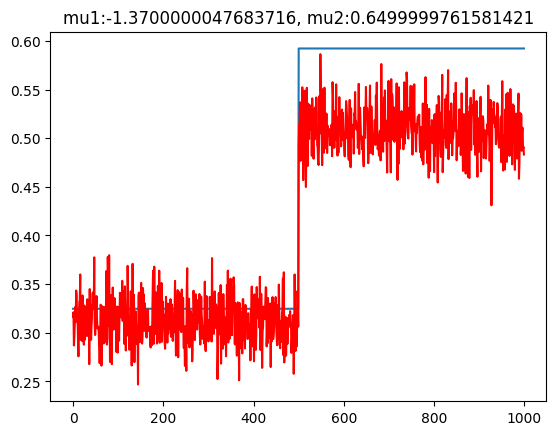

-0.15 -4.26 tensor(1.4617) tensor(-1.5576)


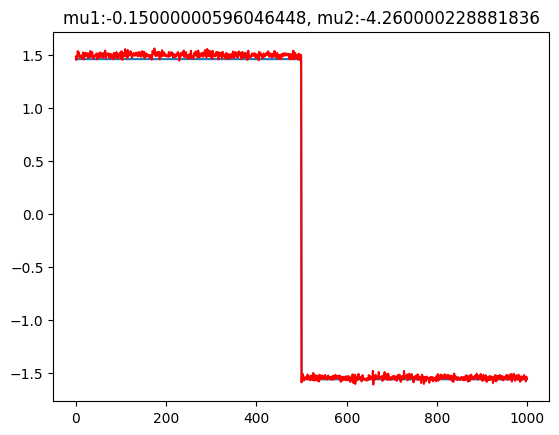

-2.57 0.3 tensor(0.8325) tensor(0.8601)


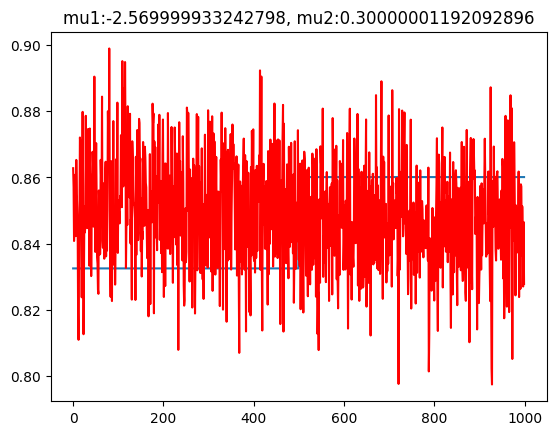

-0.27 -1.27 tensor(0.4784) tensor(-0.4139)


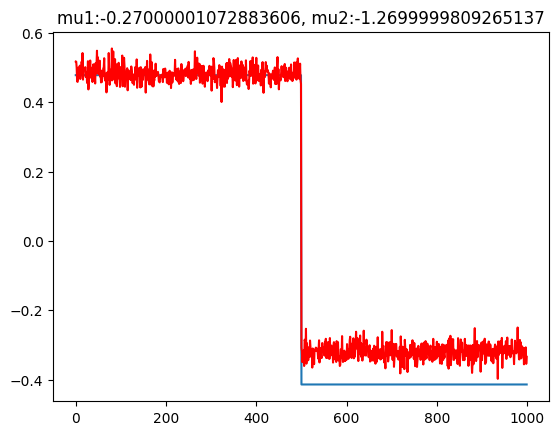

-1.99 0.46 tensor(0.5864) tensor(0.7322)


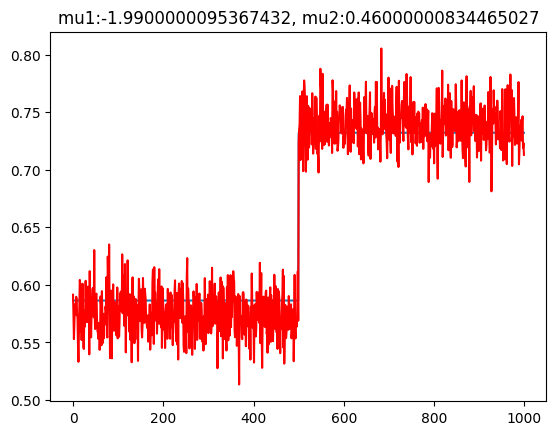

0.74 1.09 tensor(-0.6156) tensor(0.1624)


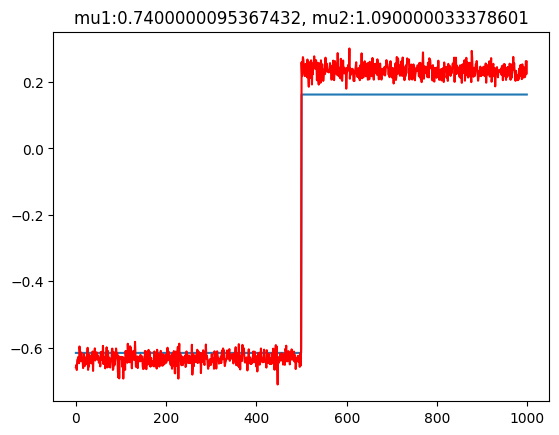

0.01 3.77 tensor(-1.0199) tensor(1.4082)


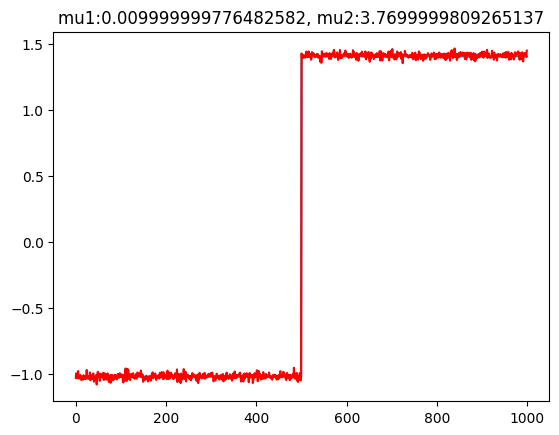

3.17 -1.02 tensor(-0.8176) tensor(-1.4496)


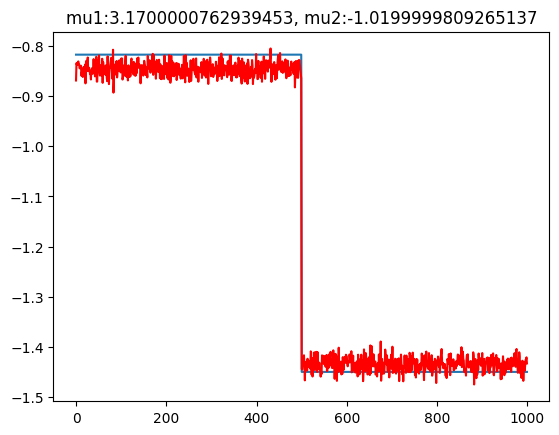

In [20]:
for i in range(32):
    plt.plot(arrays[i])
    plt.plot(reconstructed_images[i], color='r')
    mu1 = np.round(mu_np[i,0],2)
    mu2=np.round(mu_np[i,1],2)
    print(mu1,mu2, arrays[i][0], arrays[i][-1])
    plt.title(f'mu1:{mu1}, mu2:{mu2}')
    plt.show()

In [21]:
mu_np.shape[0]

32

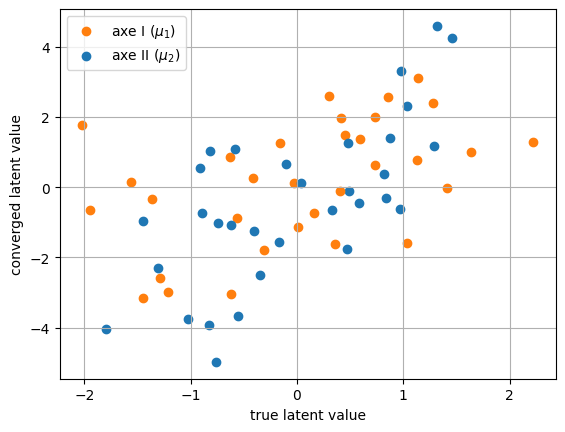

In [23]:
for i in range(mu_np.shape[0]):
    mu1 = np.round(mu_np[i,0],2)
    mu2=np.round(mu_np[i,1],2)
    #print(mu1,mu2, arrays[i][0], arrays[i][-1])
    if i==0:
        plt.scatter(arrays[i][-1],mu2,c='tab:orange', label=r'axe I ($\mu_1$)')
        plt.scatter(arrays[i][0],-mu1,  c='tab:blue', label=r'axe II ($\mu_2$)')
    else:
        plt.scatter(arrays[i][-1],mu2,c='tab:orange' )
        plt.scatter(arrays[i][0],-mu1,  c='tab:blue')
    plt.xlabel('true latent value')
    plt.ylabel('converged latent value')
    plt.grid(True)
    plt.legend()
    #plt.title(f'mu1:{mu1}, mu2:{mu2}')
    #plt.show()

In [27]:
vae.eval()  # Ensure the VAE is in evaluation mode
mu_list=[]
with torch.no_grad():
    for i_b, batch in enumerate(train_loader):
        x = batch[0]  # assuming the data comes as (input, label) tuples
        x = x.to(device)  # Move input to the appropriate device
        
        # Get the latent mean (mu) and log variance (logvar)
        mu, logvar = vae.encode(x)
        
        

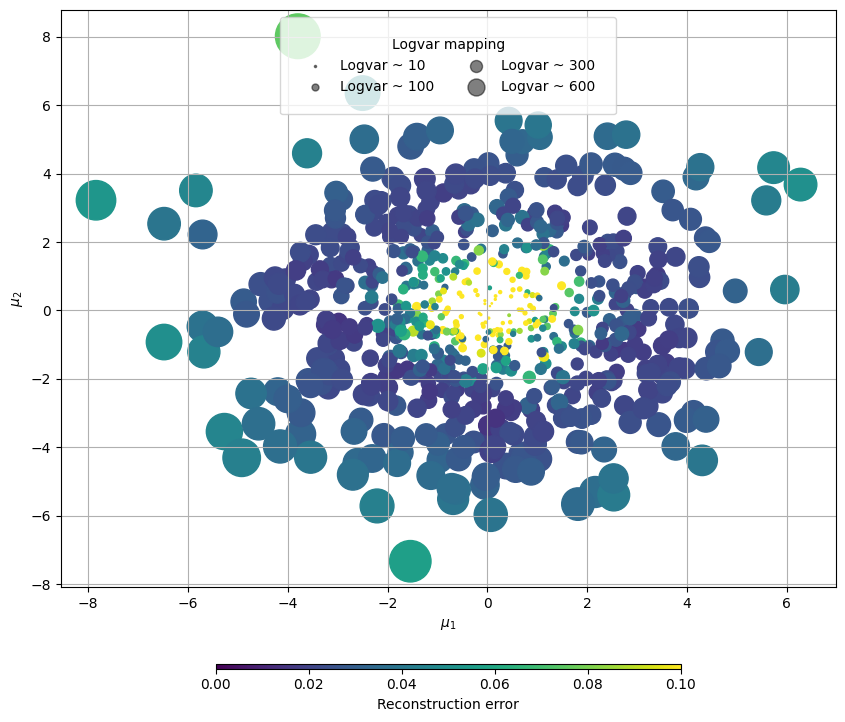

In [28]:
vae.eval()  # Ensure the VAE is in evaluation mode
mu_list=[]

fig = plt.figure(figsize=(10,10))
with torch.no_grad():
    for i_b, batch in enumerate(train_loader):
        x = batch[0]  # assuming the data comes as (input, label) tuples
        
        recon_x, mu, logvar = vae(x)
        recon_loss = (recon_x - x) ** 2#, reduction='sum')


        x = x.to(device)  # Move input to the appropriate device
        
        # Get the latent mean (mu) and log variance (logvar)
        #mu, logvar = vae.encode(x)
        recon_loss = recon_loss.detach().cpu().numpy()
        mu_np = mu.detach().cpu().numpy()  
        logvar_np = logvar.detach().cpu().numpy()
        #mu_list.extend(mu_np[:,0])
        im=plt.scatter(mu_np[:,0], mu_np[:,1], sizes=logvar_np[:,0]**2+logvar_np[:,1]**2, c=np.sqrt(np.mean(recon_loss, axis=-1)), vmin=0, vmax=0.1)
        #plt.show()

size_legend = [10, 100, 300, 600]  # Define some sizes to display in the legend
for size in size_legend:
    plt.scatter([], [], s=size, label=f'Logvar ~ {size}', alpha=0.5, color='k')

# Show the legend
plt.legend(title='Logvar mapping',loc='upper center', borderpad=1.5, markerscale=0.5, frameon=True, ncols=2)
plt.grid(True)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(im, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='Reconstruction error')
#plt.scatter((x1_list-np.mean(x1_list))/np.std(x1_list),(eps2_list-np.mean(eps2_list))/np.std(eps2_list), c='k', alpha=0.2)
#plt.scatter(a_list, b_list, c='k', alpha=0.2)


In [54]:
all_array.shape

(1000, 1000)

In [72]:
np.sqrt(np.sum(all_array[0]**2)) == np.linalg.norm(all_array[0], axis=-1)

True

In [99]:
all_array_norms = np.linalg.norm(train_dataset, axis=-1)/100

(array([ 48., 142., 164., 128., 103.,  61.,  30.,  15.,   7.,   2.]),
 array([0.00440129, 0.0879146 , 0.17142791, 0.25494123, 0.33845454,
        0.42196783, 0.50548118, 0.58899444, 0.67250776, 0.75602108,
        0.8395344 ]),
 <BarContainer object of 10 artists>)

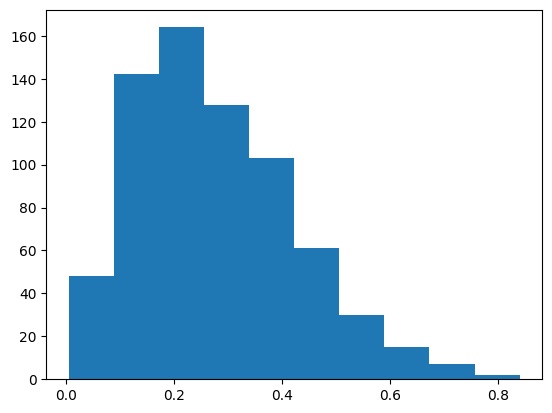

In [100]:
plt.hist(all_array_norms)

In [101]:
vae.eval()  # Ensure the VAE is in evaluation mode
mu1_list=[]
mu2_list=[]
fig = plt.figure(figsize=(10,10))
with torch.no_grad():
    for i_b, batch in enumerate(train_loader):
        x = batch[0]  # assuming the data comes as (input, label) tuples
        recon_x, mu, logvar = vae(x)

        mu_np = mu.detach().cpu().numpy()  

        mu1_list.extend(mu_np[:,0])
        mu2_list.extend(mu_np[:,1])

mu1_list = np.array(mu1_list)
mu2_list = np.array(mu2_list)

<Figure size 1000x1000 with 0 Axes>

In [102]:
mu = np.stack((mu1_list, mu2_list), axis=0)

In [103]:
mu_norms = np.linalg.norm(mu, axis=0)

(array([ 47., 138., 164., 122., 103.,  65.,  31.,  18.,   9.,   3.]),
 array([0.08217081, 0.88883936, 1.69550788, 2.50217652, 3.30884504,
        4.11551332, 4.92218208, 5.72885036, 6.53551912, 7.3421874 ,
        8.14885616]),
 <BarContainer object of 10 artists>)

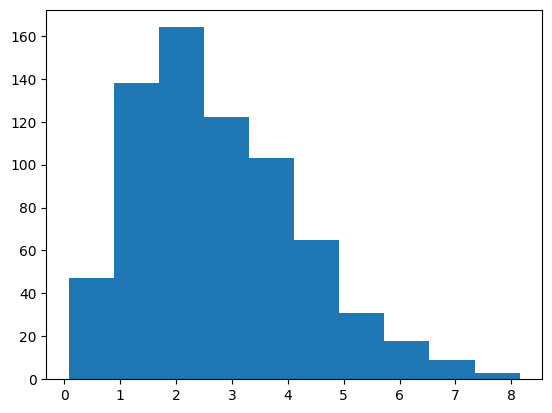

In [104]:
plt.hist(mu_norms)

In [171]:
a_list = [np.random.normal(0, 1) for i in range(200)]
b_list = [aa**2 for aa in a_list]

a_list.extend([np.random.normal(0, 1) for i in range(1000)])
b_list.extend([np.random.normal(0, 1) for i in range(1000)])

In [172]:
all_array = []
x = np.linspace(0, 100, 1000)
for i in range(1000):
    a = a_list[i]
    b = b_list[i]
    signal = split_function(x, a, b)
    all_array.append(signal)
all_array = np.array(all_array)

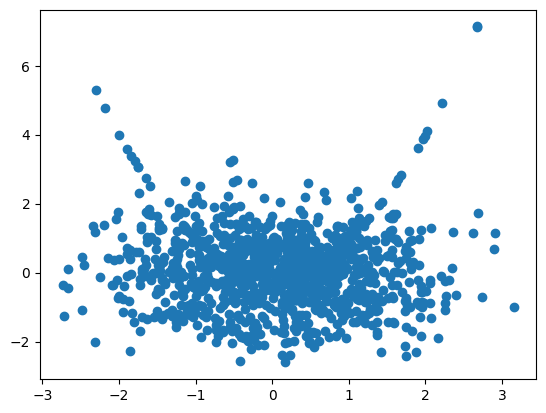

In [173]:
plt.scatter(a_list, b_list)

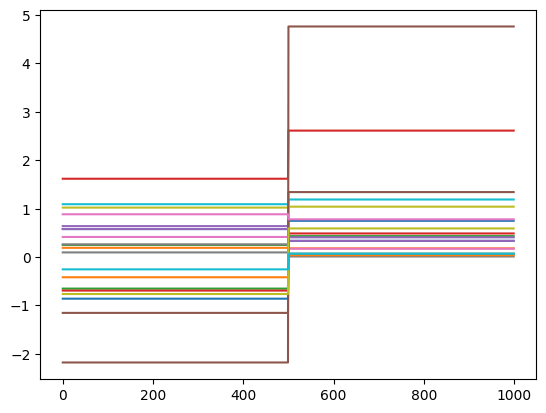

In [174]:
for i in range(20):
    plt.plot(all_array[i])

In [175]:
# Set the split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
total_samples = all_array.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle the data (optional, but common in dataset splitting)
indices = np.random.permutation(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = all_array[train_indices]
val_data = all_array[val_indices]
test_data = all_array[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching during training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [176]:

_, input_dim = all_array.shape

# Instantiate the VAE
latent_dim = 80  # Latent space dimension
vae = VAE(input_dim=input_dim)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=5e-5)


In [177]:
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
min_delta = 0  # Minimum change to qualify as an improvement
best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 0  # Count how long the validation loss hasn't improved

# Training loop with early stopping
epochs = 500
for epoch in range(epochs):
    total_loss = 0
    vae.train()  # Set VAE to training mode
    
    # Training step
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar, beta=1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}", end="\r")
    
    # Validation step
    vae.eval()  # Set VAE to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_batch in val_loader:
            x_val = val_batch[0]
            recon_x_val, mu_val, logvar_val = vae(x_val)
            val_loss = vae_loss(recon_x_val, x_val, mu_val, logvar_val, beta=1)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}",end="\r")

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
    
    # Check if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Ensure the final epoch result is printed properly
print(f"Training Complete. Final Train Loss: {avg_train_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")


Early stopping triggered at epoch 97al Loss: 15.862291
Training Complete. Final Train Loss: 19.3058, Best Val Loss: 14.8172


In [190]:
# Test the VAE with a batch of images
vae.eval()  # Set VAE to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of images from the DataLoader
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
arrays = next(data_iter)  # Get a batch of images

# Since there's only one tensor in the dataset, access it with [0]
arrays = arrays[0].to(device)  # Move to GPU if available

# Pass the images through the VAE
with torch.no_grad():
    reconstructed_images = vae(arrays)  # Decode the images
    reconstructed_images = reconstructed_images[0]
    mu, logvar = vae.encode(arrays)
    mu_np = mu.detach().cpu().numpy()  

4.56 2.64 tensor(-0.9332) tensor(-1.8652)


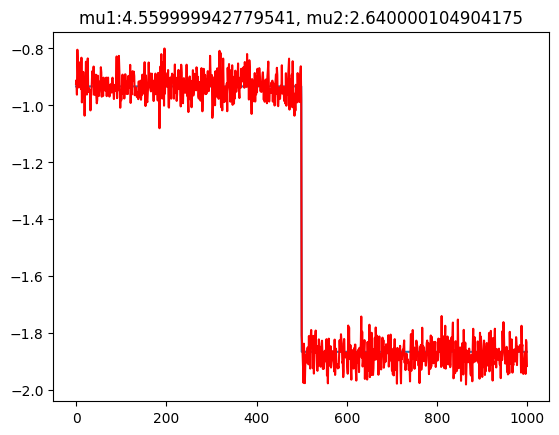

0.84 -0.9 tensor(-0.4709) tensor(0.2218)


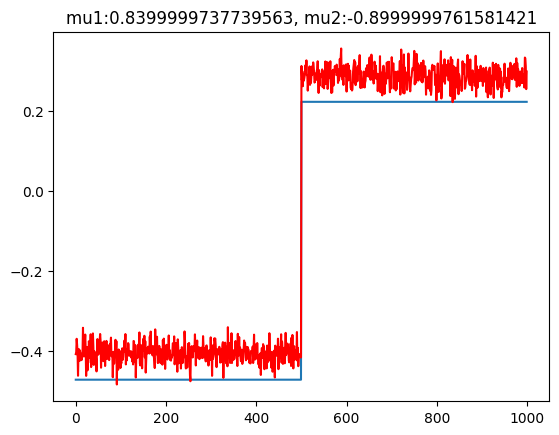

-6.28 -2.96 tensor(1.6446) tensor(2.7046)


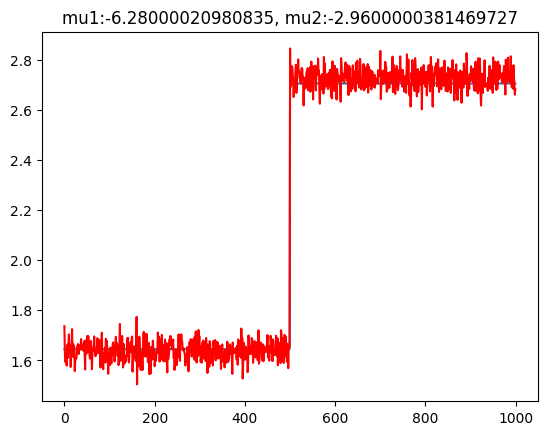

-1.39 -0.27 tensor(0.4479) tensor(0.4553)


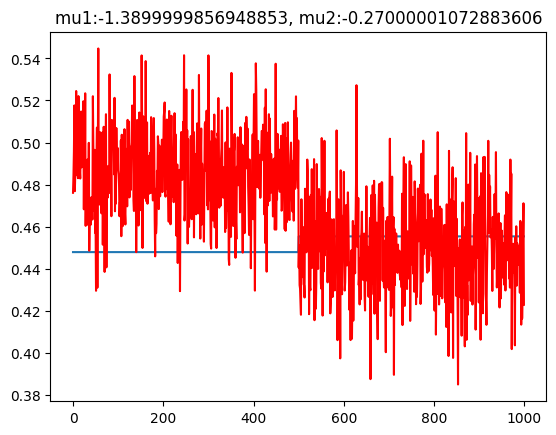

-1.92 -0.41 tensor(0.6098) tensor(0.6376)


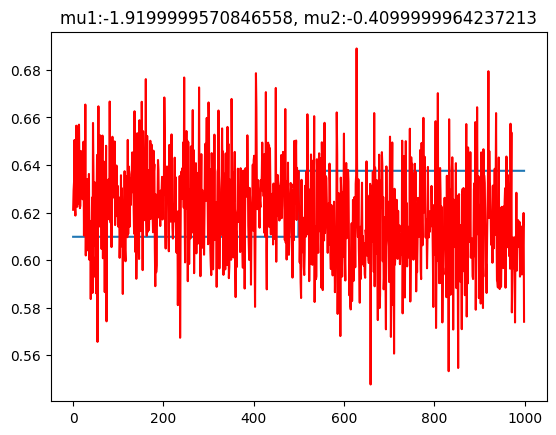

-2.72 5.17 tensor(2.2495) tensor(-1.0961)


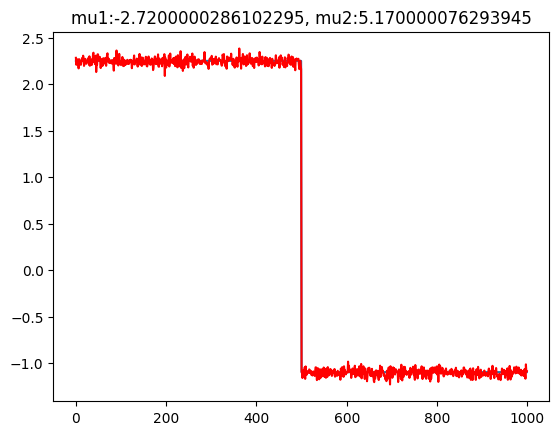

1.92 -0.0 tensor(-0.6515) tensor(-0.3150)


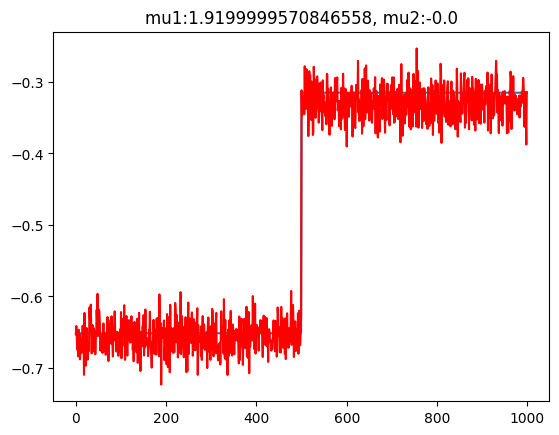

-2.17 -4.0 tensor(-0.1027) tensor(2.1545)


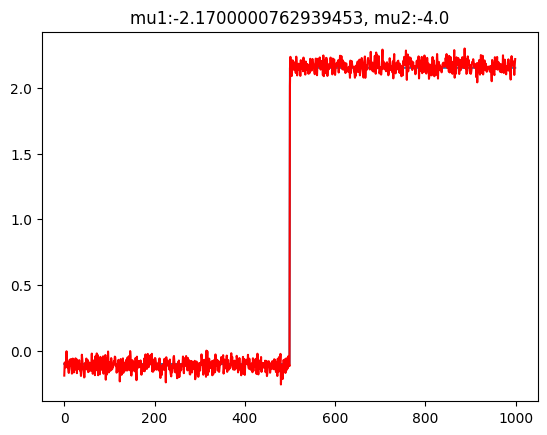

2.52 1.01 tensor(-0.6164) tensor(-0.8242)


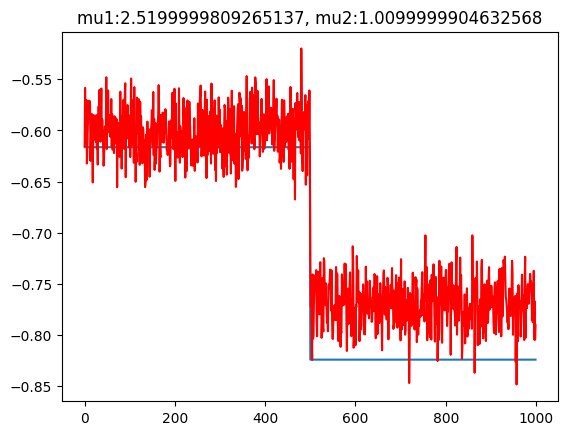

-0.94 -3.84 tensor(-0.5147) tensor(1.8477)


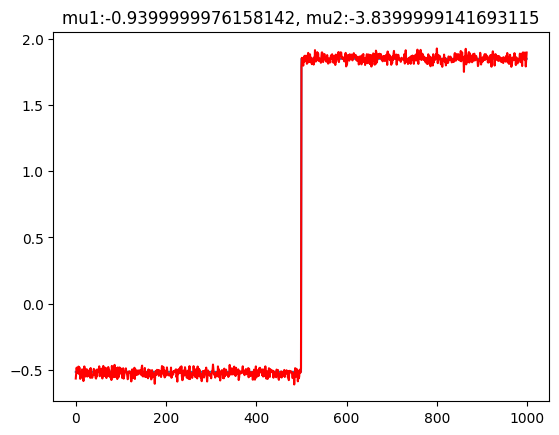

5.97 1.58 tensor(-1.7224) tensor(-1.6938)


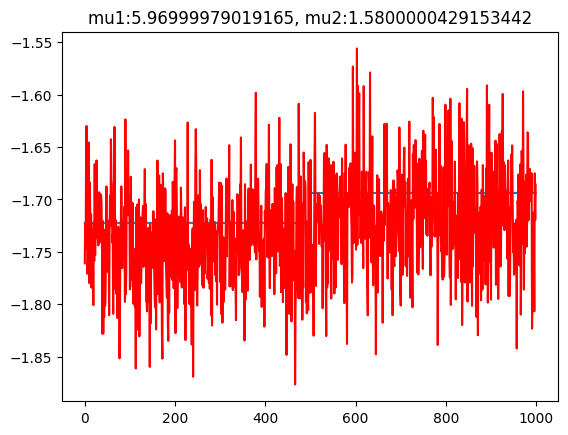

-4.01 1.2 tensor(1.7308) tensor(0.6231)


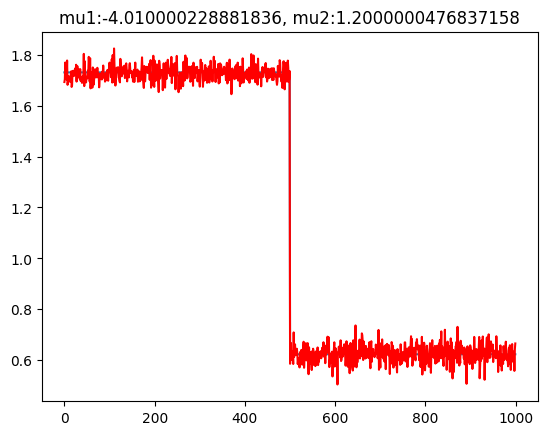

0.96 -1.39 tensor(-0.6344) tensor(0.4025)


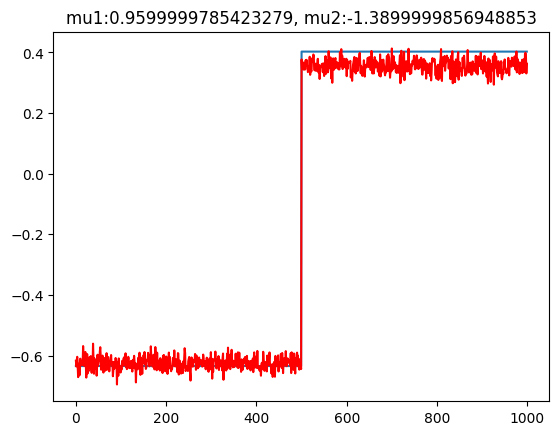

-0.68 -0.2 tensor(0.2079) tensor(0.2540)


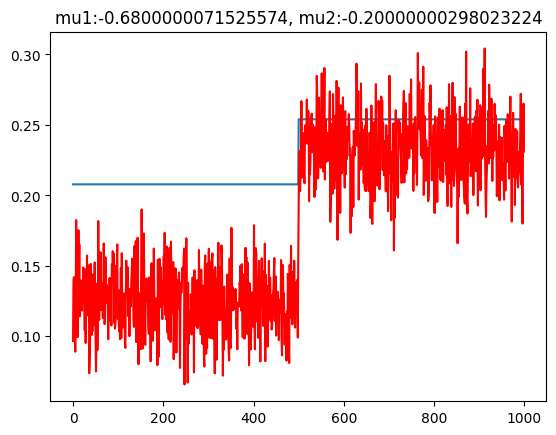

-1.06 0.27 tensor(0.4409) tensor(0.1944)


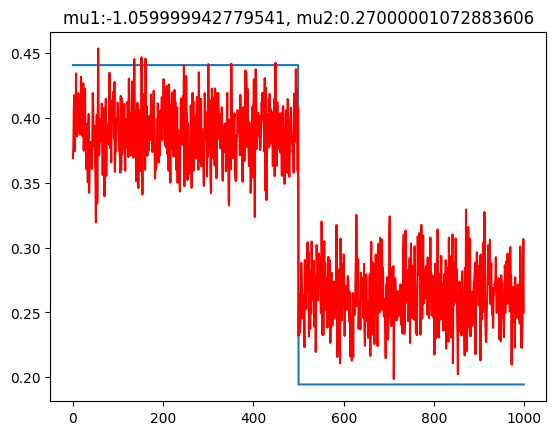

2.45 -0.43 tensor(-0.9537) tensor(-0.2358)


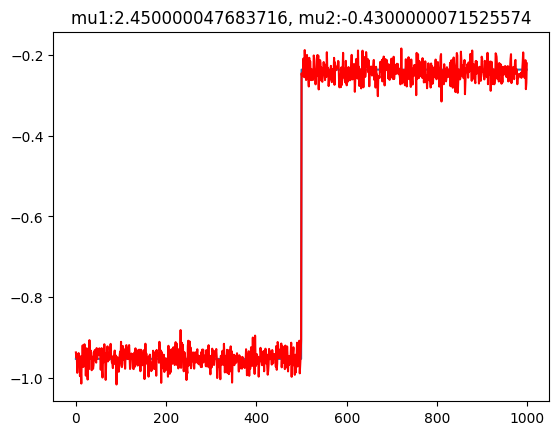

0.71 4.99 tensor(0.9617) tensor(-1.8972)


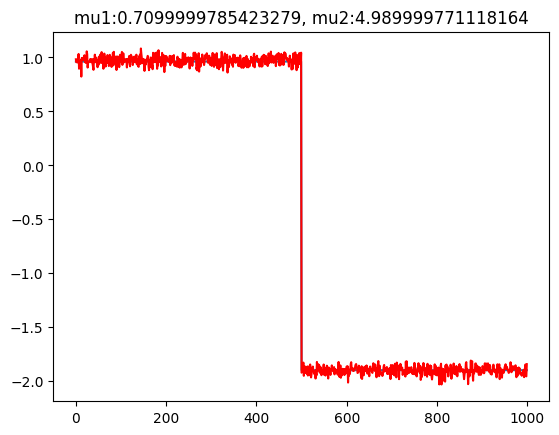

1.8 1.31 tensor(-0.2848) tensor(-0.7936)


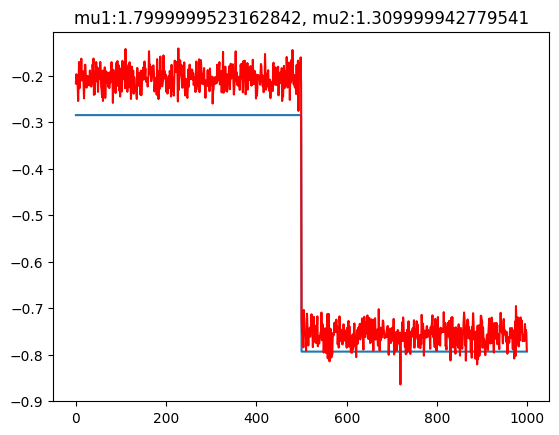

3.54 -0.66 tensor(-1.4054) tensor(-0.3395)


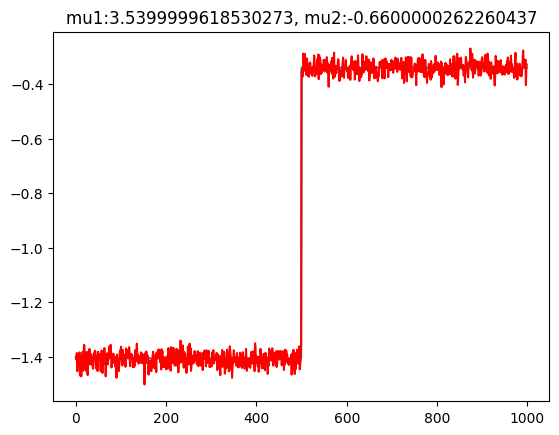

-0.13 0.91 tensor(0.2618) tensor(-0.2503)


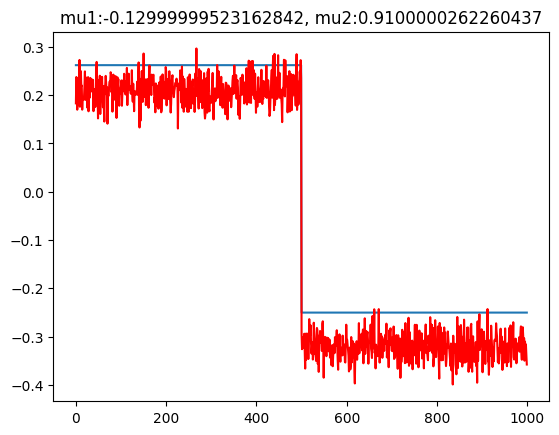

-3.39 1.16 tensor(1.4966) tensor(0.4824)


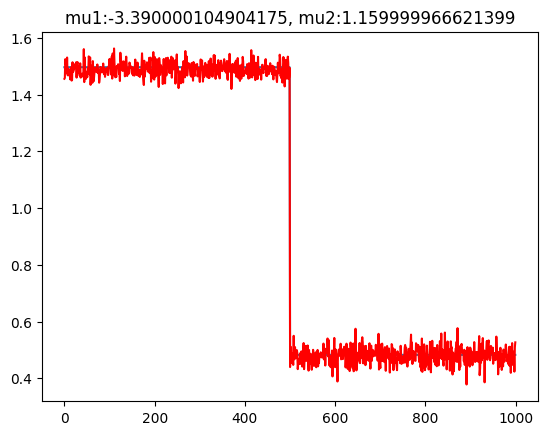

-1.98 0.81 tensor(0.9006) tensor(0.2474)


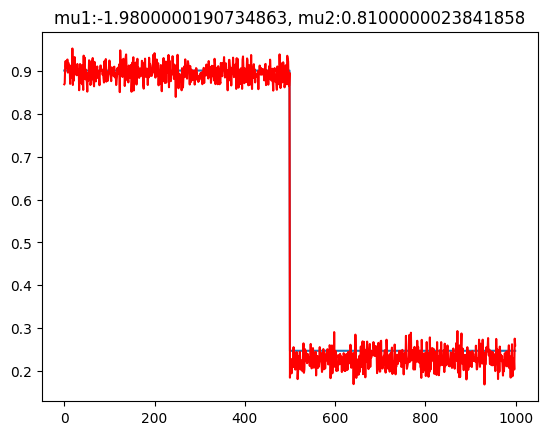

-0.11 -2.43 tensor(-0.4907) tensor(1.0893)


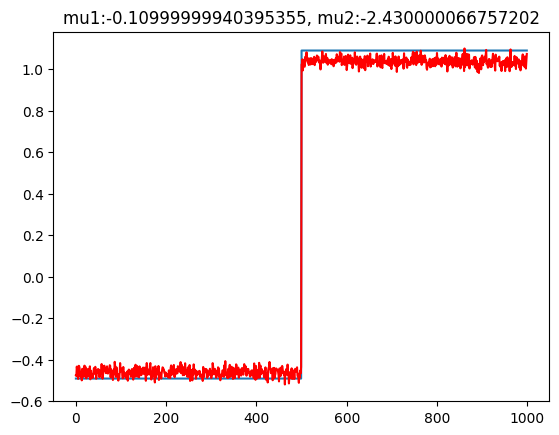

-0.1 4.17 tensor(1.0569) tensor(-1.4247)


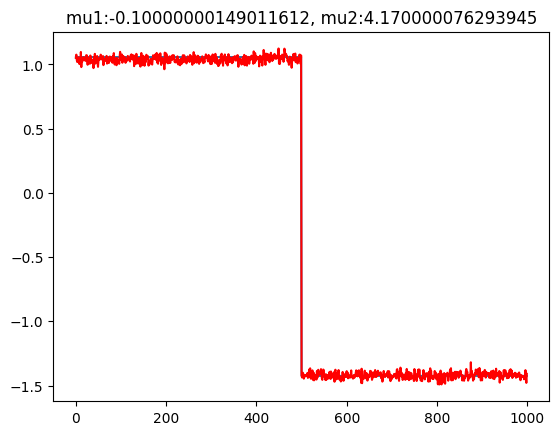

0.7 -0.43 tensor(-0.3069) tensor(0.0665)


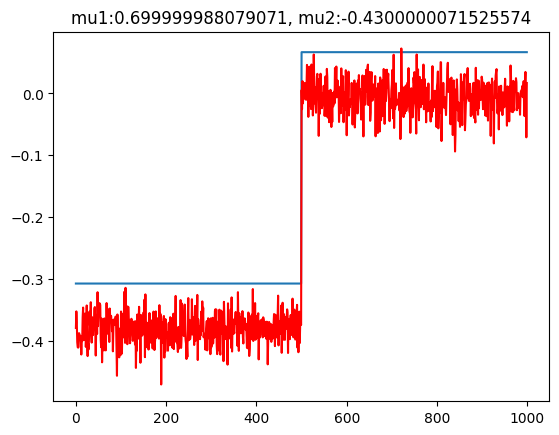

2.24 2.86 tensor(-0.0630) tensor(-1.4750)


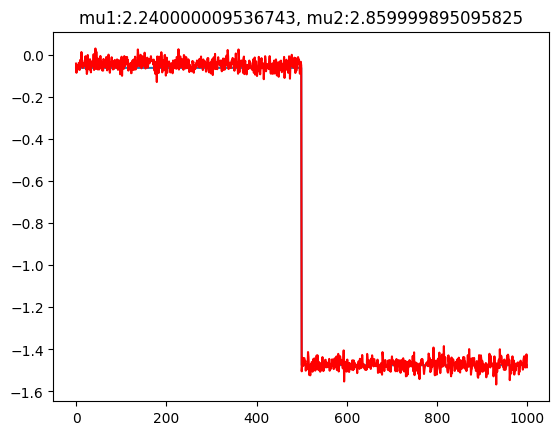

-1.99 1.66 tensor(1.1119) tensor(-0.0331)


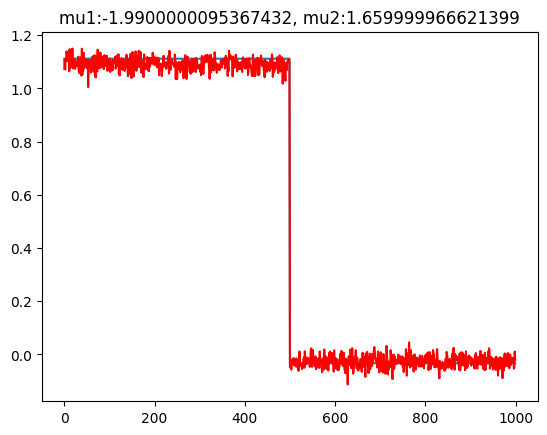

0.09 0.03 tensor(0.0025) tensor(6.2720e-06)


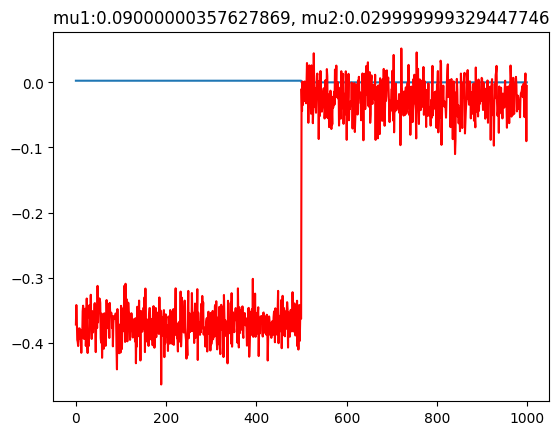

-0.55 0.28 tensor(0.2589) tensor(0.0670)


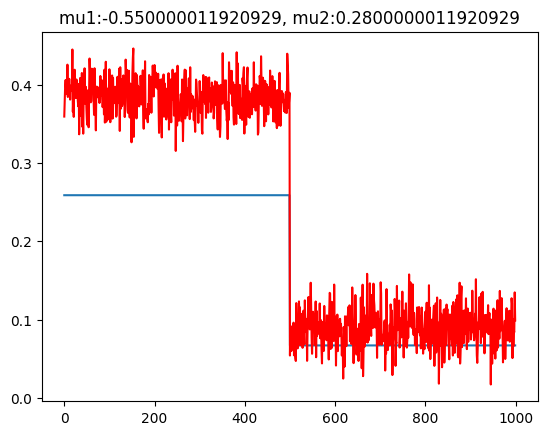

1.59 1.03 tensor(-0.2783) tensor(-0.6471)


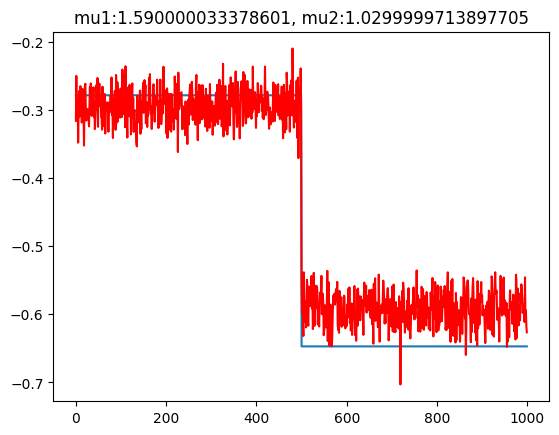

-1.36 1.33 tensor(0.8062) tensor(-0.0825)


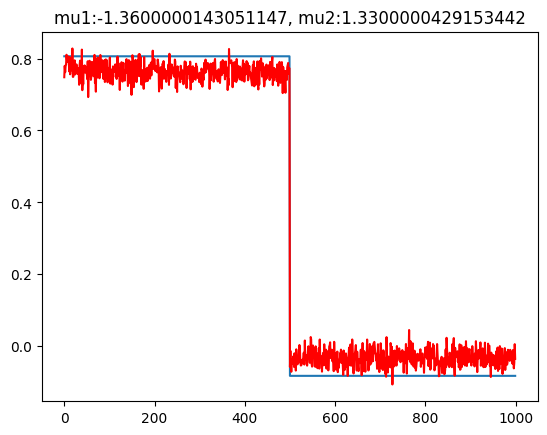

-3.55 -0.87 tensor(1.0989) tensor(1.2075)


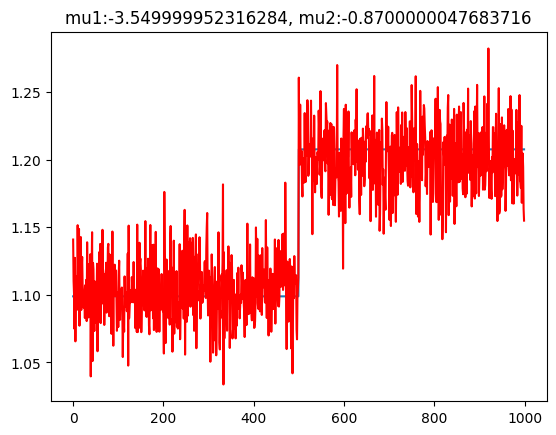

In [191]:
for i in range(32):
    plt.plot(arrays[i])
    plt.plot(reconstructed_images[i], color='r')
    mu1 = np.round(mu_np[i,0],2)
    mu2=np.round(mu_np[i,1],2)
    print(mu1,mu2, arrays[i][0], arrays[i][-1])
    plt.title(f'mu1:{mu1}, mu2:{mu2}')
    plt.show()

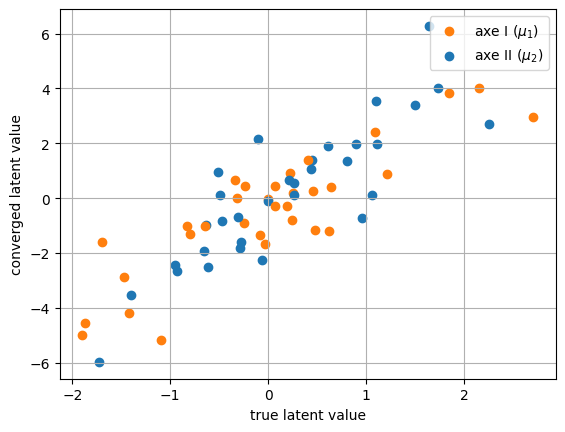

In [193]:
for i in range(mu_np.shape[0]):
    mu1 = np.round(mu_np[i,0],2)
    mu2=np.round(mu_np[i,1],2)
    #print(mu1,mu2, arrays[i][0], arrays[i][-1])
    if i==0:
        plt.scatter(arrays[i][-1],-mu1,c='tab:orange', label=r'axe I ($\mu_1$)')
        plt.scatter(arrays[i][0],-mu2,  c='tab:blue', label=r'axe II ($\mu_2$)')
    else:
        plt.scatter(arrays[i][-1],-mu2,c='tab:orange' )
        plt.scatter(arrays[i][0],-mu1,  c='tab:blue')
    plt.xlabel('true latent value')
    plt.ylabel('converged latent value')
    plt.grid(True)
    plt.legend()
    #plt.title(f'mu1:{mu1}, mu2:{mu2}')
    #plt.show()

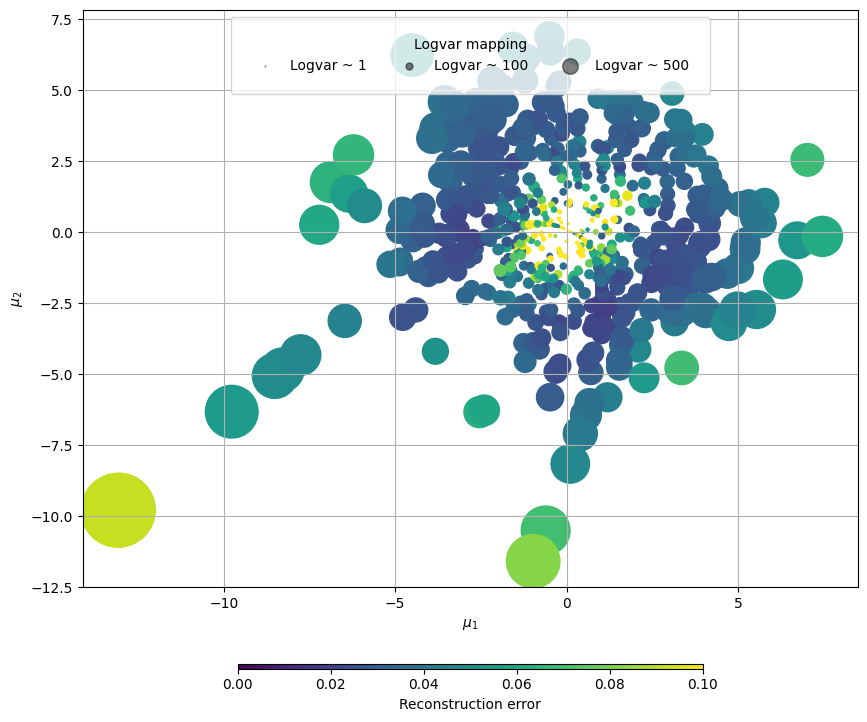

In [197]:
vae.eval()  # Ensure the VAE is in evaluation mode
mu_list=[]

fig = plt.figure(figsize=(10,10))
with torch.no_grad():
    for i_b, batch in enumerate(train_loader):
        x = batch[0]  # assuming the data comes as (input, label) tuples
        
        recon_x, mu, logvar = vae(x)
        recon_loss = (recon_x - x) ** 2#, reduction='sum')


        x = x.to(device)  # Move input to the appropriate device
        
        # Get the latent mean (mu) and log variance (logvar)
        #mu, logvar = vae.encode(x)
        recon_loss = recon_loss.detach().cpu().numpy()
        mu_np = mu.detach().cpu().numpy()  
        logvar_np = logvar.detach().cpu().numpy()
        #mu_list.extend(mu_np[:,0])
        im=plt.scatter(mu_np[:,0], mu_np[:,1], sizes=logvar_np[:,0]**2+logvar_np[:,1]**2, c=np.sqrt(np.mean(recon_loss, axis=-1)), vmin=0, vmax=0.1)
        #plt.show()

size_legend = [1, 100, 500]  # Define some sizes to display in the legend
for size in size_legend:
    plt.scatter([], [], s=size, label=f'Logvar ~ {size}', alpha=0.5, color='k')

# Show the legend
plt.legend(title='Logvar mapping',loc='upper center', borderpad=1.5, markerscale=0.5, frameon=True, ncols=3)
plt.grid(True)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(im, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='Reconstruction error')
#plt.scatter((x1_list-np.mean(x1_list))/np.std(x1_list),(eps2_list-np.mean(eps2_list))/np.std(eps2_list), c='k', alpha=0.2)
#plt.scatter(a_list, b_list, c='k', alpha=0.2)


In [195]:
vae.eval()  # Ensure the VAE is in evaluation mode
mu1_list=[]
mu2_list=[]
fig = plt.figure(figsize=(10,10))
with torch.no_grad():
    for i_b, batch in enumerate(train_loader):
        x = batch[0]  # assuming the data comes as (input, label) tuples
        recon_x, mu, logvar = vae(x)

        mu_np = mu.detach().cpu().numpy()  

        mu1_list.extend(mu_np[:,0])
        mu2_list.extend(mu_np[:,1])

mu1_list = np.array(mu1_list)
mu2_list = np.array(mu2_list)

<Figure size 1000x1000 with 0 Axes>

(array([  4.,   1.,   6.,  19.,  73., 180., 248.,  99.,  59.,  11.]),
 array([-11.58838367,  -9.74007893,  -7.89177465,  -6.04347038,
         -4.19516611,  -2.3468616 ,  -0.49855718,   1.34974718,
          3.19805169,   5.0463562 ,   6.89466047]),
 <BarContainer object of 10 artists>)

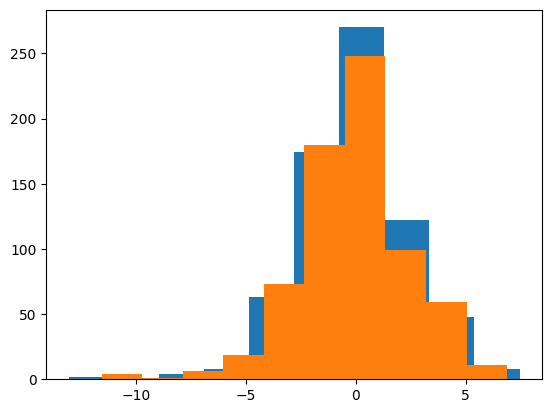

In [196]:
plt.hist(mu1_list)
plt.hist(mu2_list)

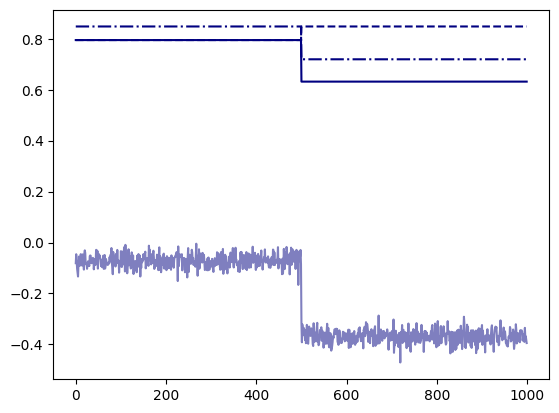

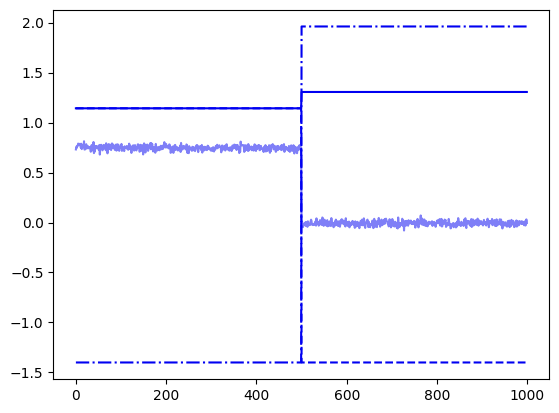

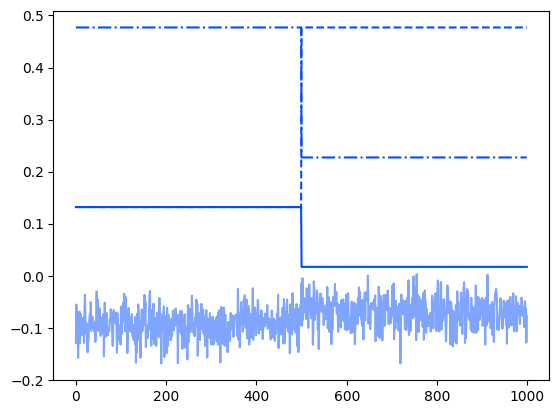

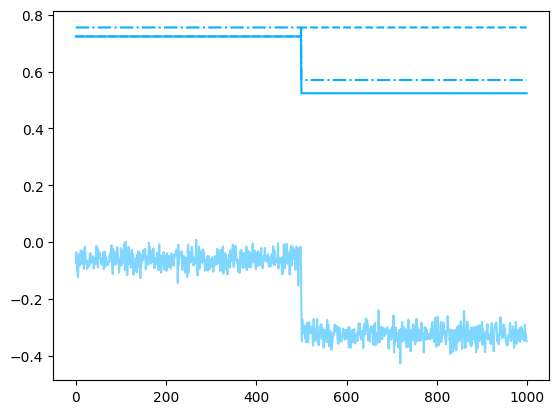

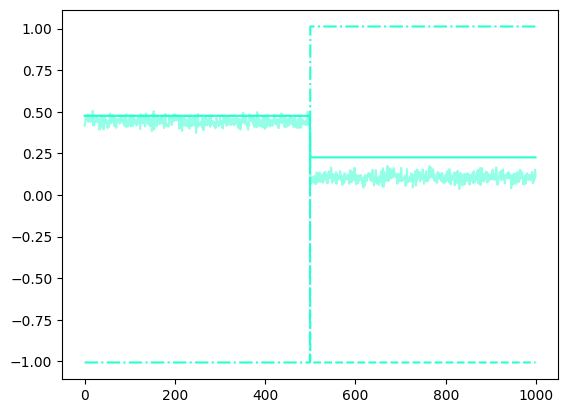

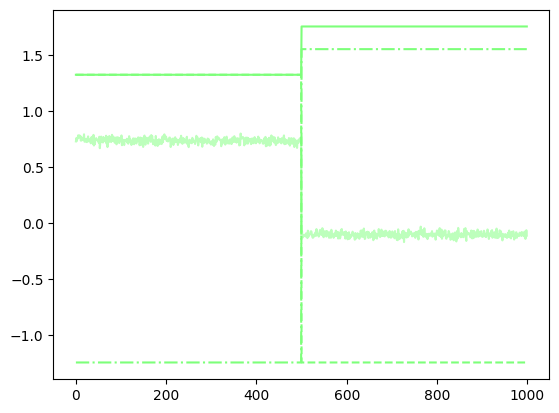

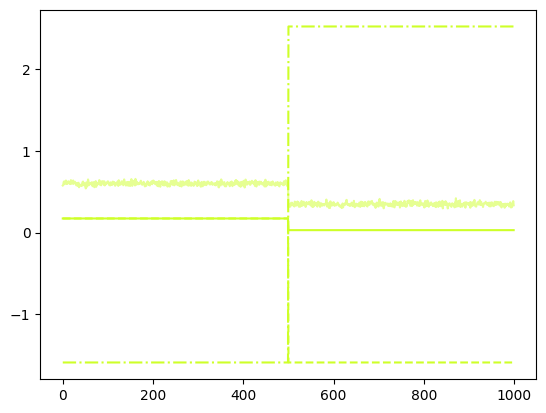

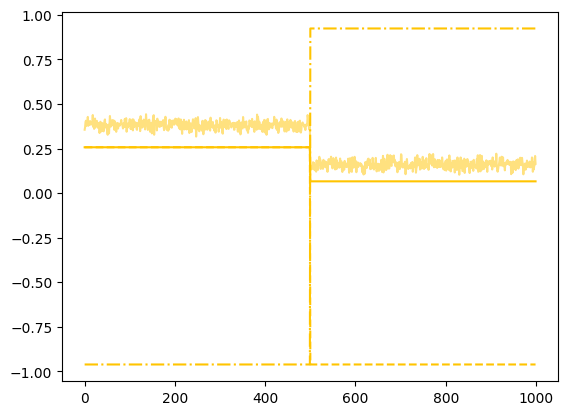

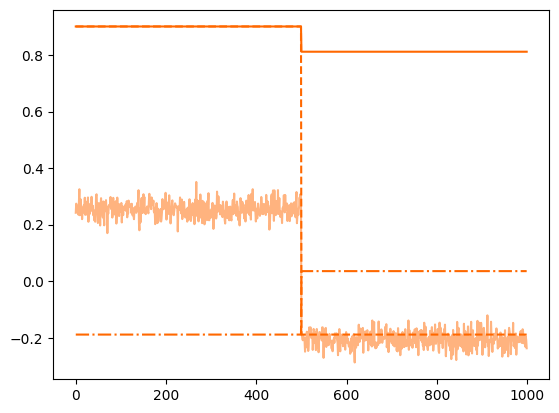

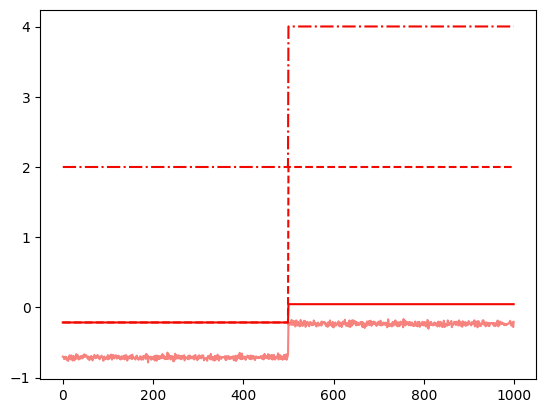

In [184]:
x = np.linspace(0,1000,1000)
cmap=plt.get_cmap('jet')
N=10
for i in range(N):
    a = np.random.normal(0,1)
    b = np.random.normal(0,1)
    latent_vector = [b, a]

    # Convert it to a torch tensor and add a batch dimension (unsqueeze(0))
    latent_tensor = torch.tensor(latent_vector).unsqueeze(0)  # Shape will be (1, 2)

    # Decode using the VAE model's decoder
    decoded_output = vae.decode(latent_tensor)

    plt.plot(decoded_output.detach().numpy()[0], color=cmap(i/N), alpha=0.5)
    signal1 = split_function(x, a, b)
    plt.plot(signal1, ls='--', color=cmap(i/N))
    signal2 = split_function(x, a, a**2)
    plt.plot(signal2, ls='-', color=cmap(i/N))
    signal3 = split_function(x, b, b**2)
    plt.plot(signal3, ls='-.', color=cmap(i/N))
    plt.show()
